agents:
    user
enviroment:
    market
    
user:
type -> normal user/ top user
different age group 
transaction frequency
carbon footprint
purchase opinion

agent interactions:
transfer

market:
carbon footprint



In [102]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import random
from matplotlib.pyplot import figure
from itertools import chain

In [109]:
class Agent:
    def __init__(self, agent_type):
        self.ag_type = agent_type
        self.age = random.choices(['Adult', 'Middle Age', 'Senior'], weights=[0.852, 0.117, 0.031], k=1)
        self.frequency = 0
        self.create = 0
        #self.budget = 85000
        self.carbon = 0
        self.opinion = 0.25
        
class Decision:
    def __init__(self, n, month, ag_num, category_list, mcc):
        self.N = n
        self.days = month*30
        self.month = 0
        self.current_day = 0
        self.category_list = category_list
        self.category_weight = [0.958, 0.131, 0.135, 0.156, 0.150, 0.016, 0.001]
        self.mcc = mcc
        self.carbon = 0
        self.ag_num = ag_num
        self.category = {}
        self.new_user = 0
        self.trans_num = 0
        self.G = nx.Graph()
    
    def calculate_co2(self, ag, amount):
        if random.randint(1, 101) < self.category['prob']:
            mcc = random.choices(population=self.category['mcc'], weights=self.category['weight'], k=1)
            equation = self.mcc[mcc[0]]
        else:
            equation = self.category['equation']
        
        carbon = equation[0]*amount + equation[1] 
        if carbon < 0:
            carbon = 0
            
        self.carbon += carbon
        ag.carbon += carbon
        ag.budget -= amount
        
            
    def make_decision(self, ag):
        used_time = self.current_day - ag.create
        if ag.age == 'Adult':
            trans_min = 3
            amount = random.randint(1, 6000)
        elif ag.age == 'Middle Age':
            trans_min = 2
            amount = random.randint(1, 4000)
        else:
            trans_min = 1
            amount = random.randint(1, 2000)
        trans_max = 9 if used_time > 30*6 else 4
        if ag.frequency < random.randint(0, trans_max):
            if random.uniform(0, 1) <= ag.opinion:
                ag.frequency += 1
                self.trans_num += 1
                category = random.choices(population=self.category_list, weights=self.category_weight, k=1)
                self.category = category[0]
                self.calculate_co2(ag, amount)
    
    def make_decision_t(self, ag):
        used_time = self.current_day - ag.create
        amount = random.randint(6000, 18000)
        if random.uniform(0, 0.75) <= ag.opinion:
                ag.frequency += 1
                self.trans_num += 1
                category = random.choices(population=self.category_list, weights=self.category_weight, k=1)
                self.category = category[0]
                self.calculate_co2(ag, amount)
                self.make_decision_t(ag)
    
    def make_transfer(self, ag):
        sender = self.N.index(ag)
        receiver = random.randint(0, len(self.N)-1)
        agent = self.N[receiver]
        if agent.create != 0 and sender != receiver:
            self.G.add_edge(sender, receiver)
            freq_diff = agent.frequency - ag.frequency
            if abs(freq_diff) <= 20:
                agent.opinion += freq_diff*0.002
                ag.opinion += freq_diff*0.002
            
        
        
    def launch(self, ags, date):
        self.new_user = 0
        self.trans_num = 0
        self.carbon = 0
        self.current_day = date
        if self.current_day == 0:
            for i in range(len(ags)-1):
                self.G.add_node(i)
                
        if date < self.days/2:
            new_ag = random.randint(1, int(self.ag_num*0.004))
        elif date < self.days*2/3:
            new_ag = random.randint(int(self.ag_num*0.005), int(self.ag_num*0.01))
        else:
            new_ag = random.randint(int(self.ag_num*0.01), int(self.ag_num*0.03))
        new_ags = random.sample(ags, new_ag)
        new_payee = random.randint(0, self.ag_num*0.02)
        payees = random.sample(ags, new_payee)
        for ag in ags:
            if ag in new_ags and ag.create == 0:
                ag.create = date
                self.new_user += 1
            if ag.create != 0:
                if ag.ag_type == 't':
                    self.make_decision_t(ag)
                else:
                    self.make_decision(ag)
                if ag in payees:
                        self.make_transfer(ag)
        if date % 30 == 0:
            # user transfer graph 
            figure(figsize=(12, 12), dpi=80)
            self.G.remove_nodes_from(list(nx.isolates(self.G)))
            nx.draw(self.G, node_size=50)
            #nx.draw(self.G, pos=nx.spring_layout(self.G, k=0.15, iterations=10))
            #for component in enumerate(nx.connected_components(self.G)):
            #print(len(nx.connected_components(self.G)))
            #nx.draw(nx.connected_components(self.G))
        return self.trans_num, self.new_user, self.carbon
        
class Market:
    def __init__(self):
        self.carbon_total = 0
        self.carbon_log = 0
        
    def launch(self, carbon):
        self.carbon_total += carbon
        self.carbon_log = carbon
        return self.carbon_total, self.carbon_log

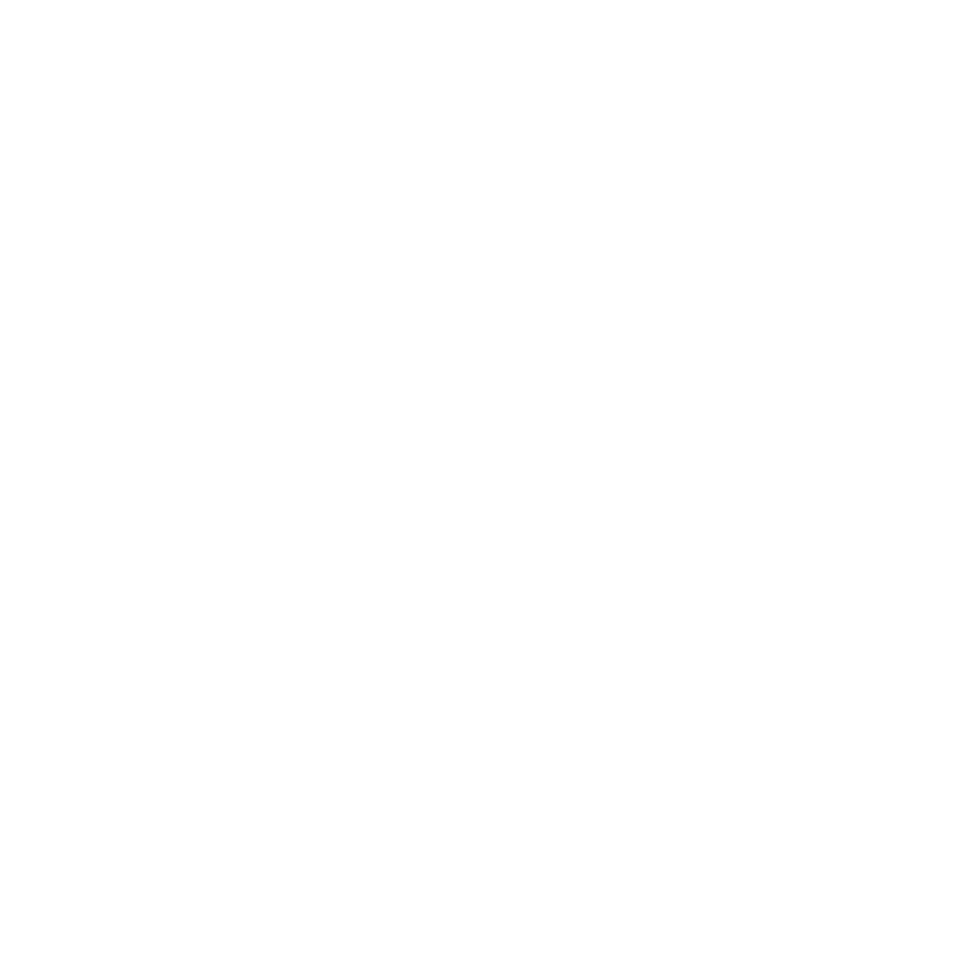

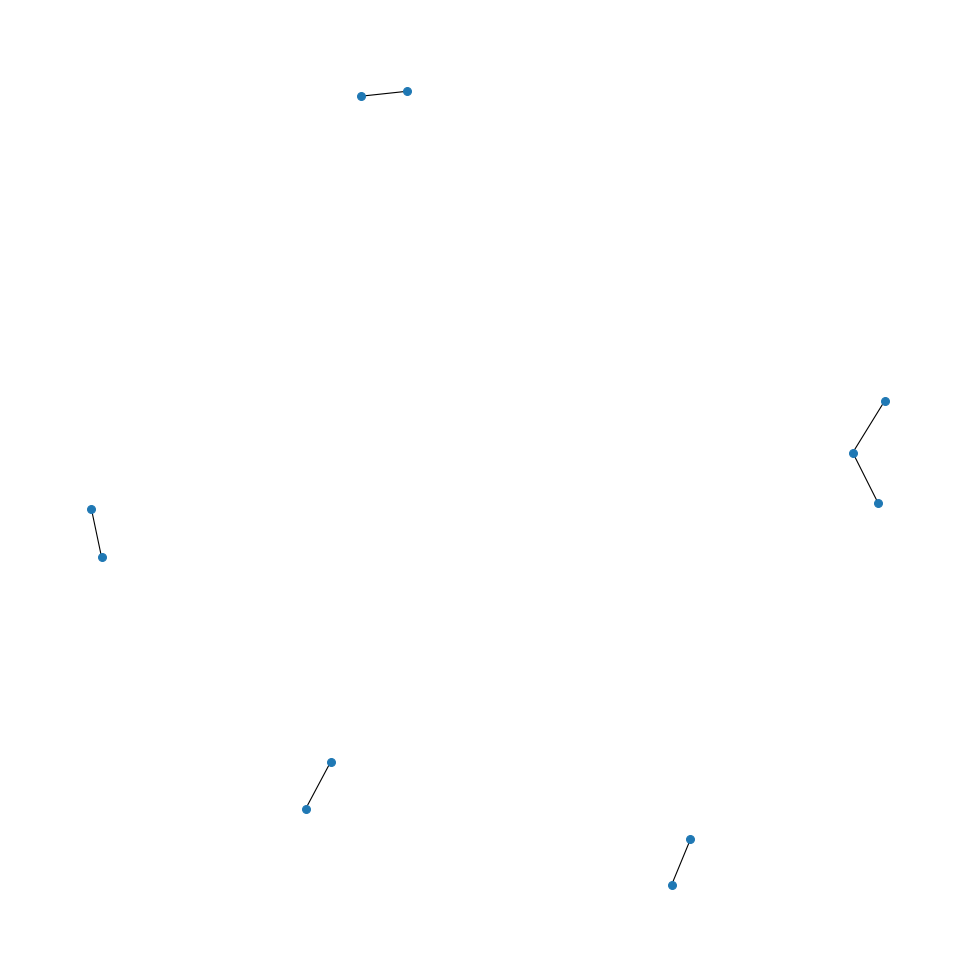

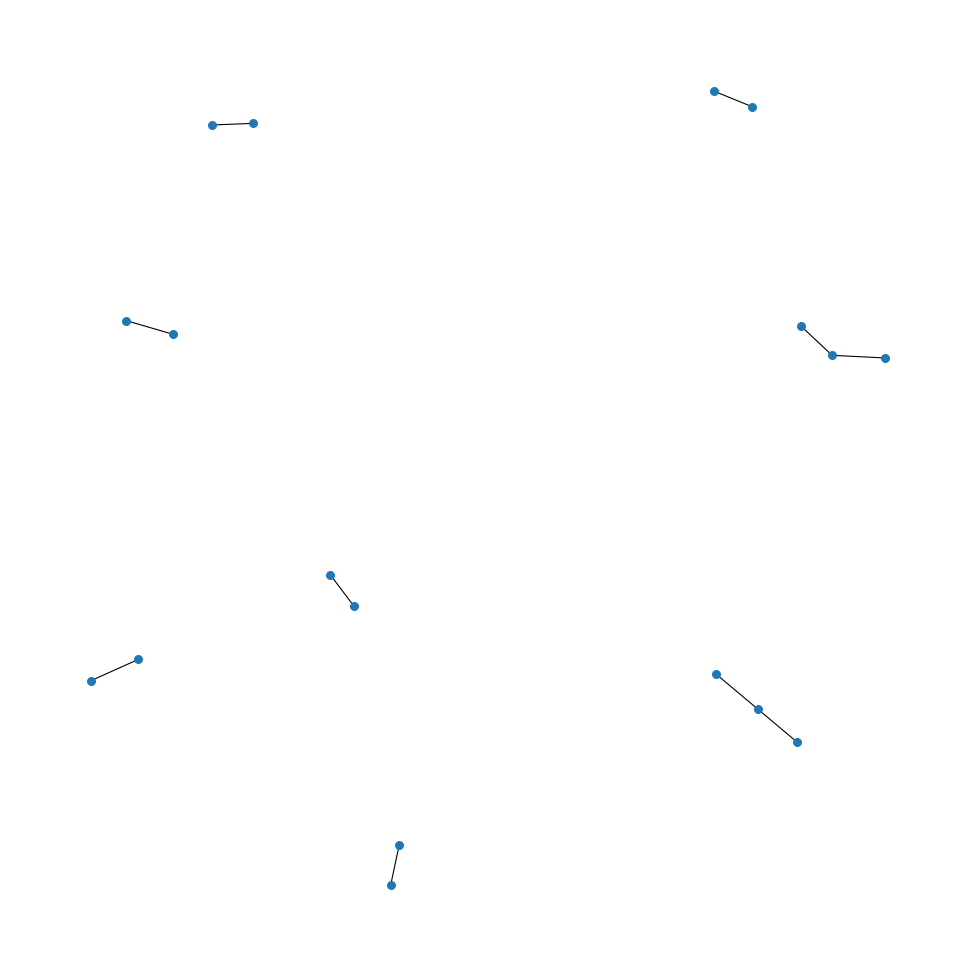

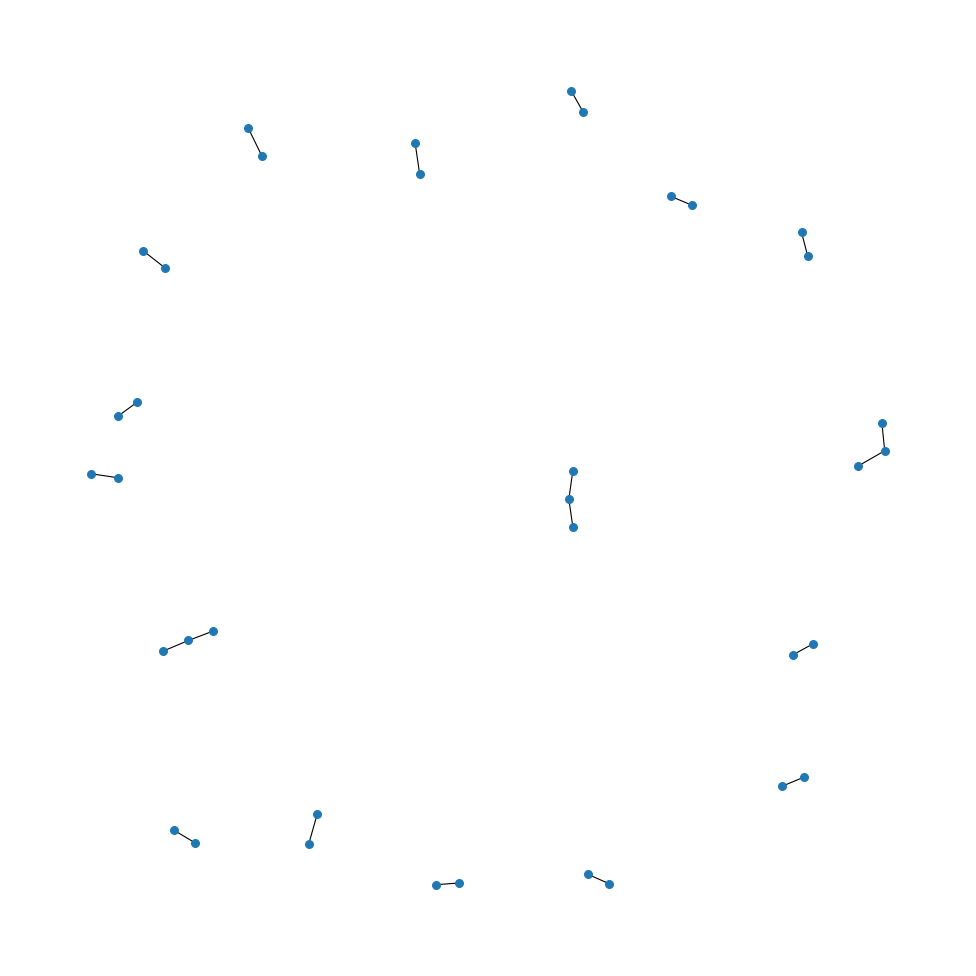

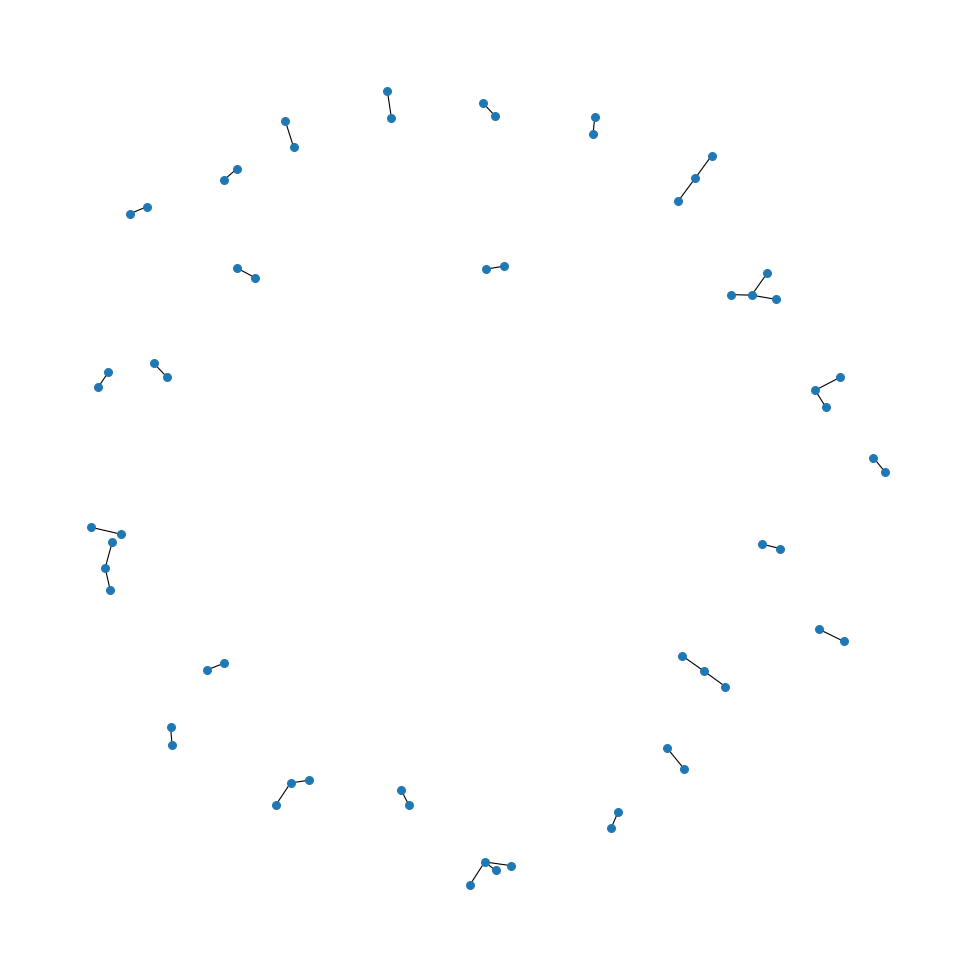

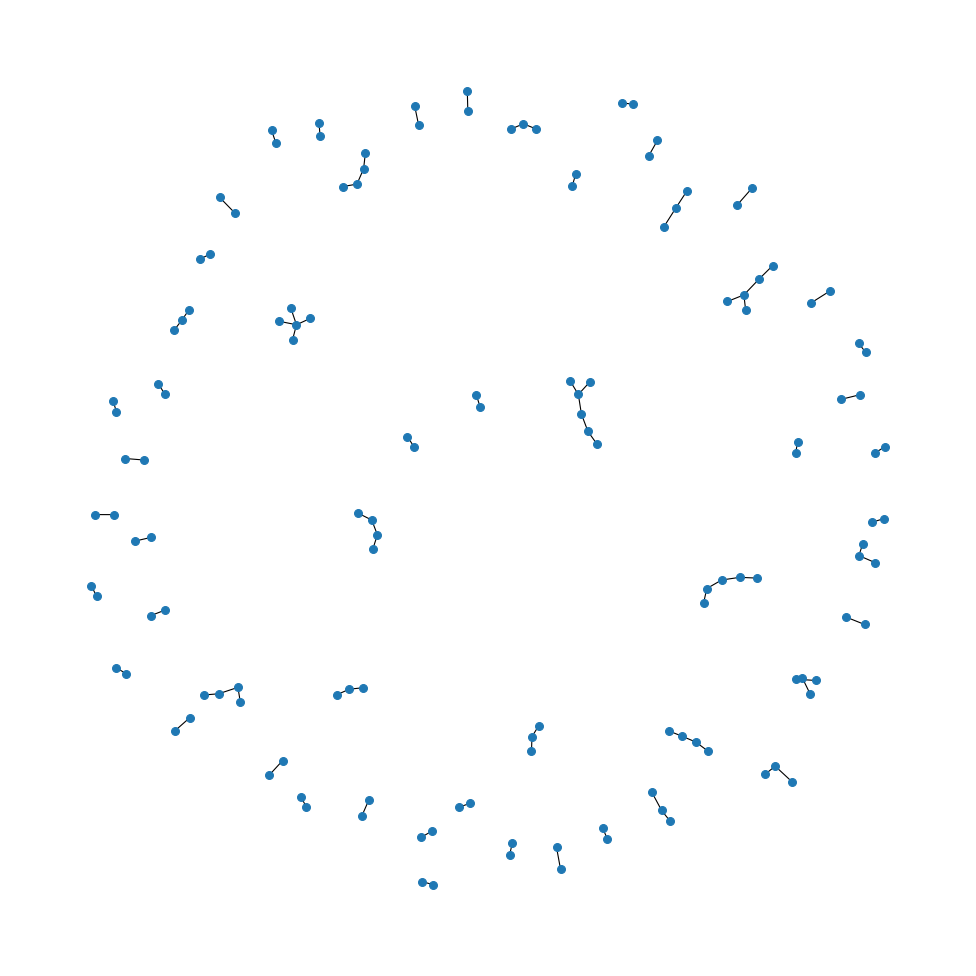

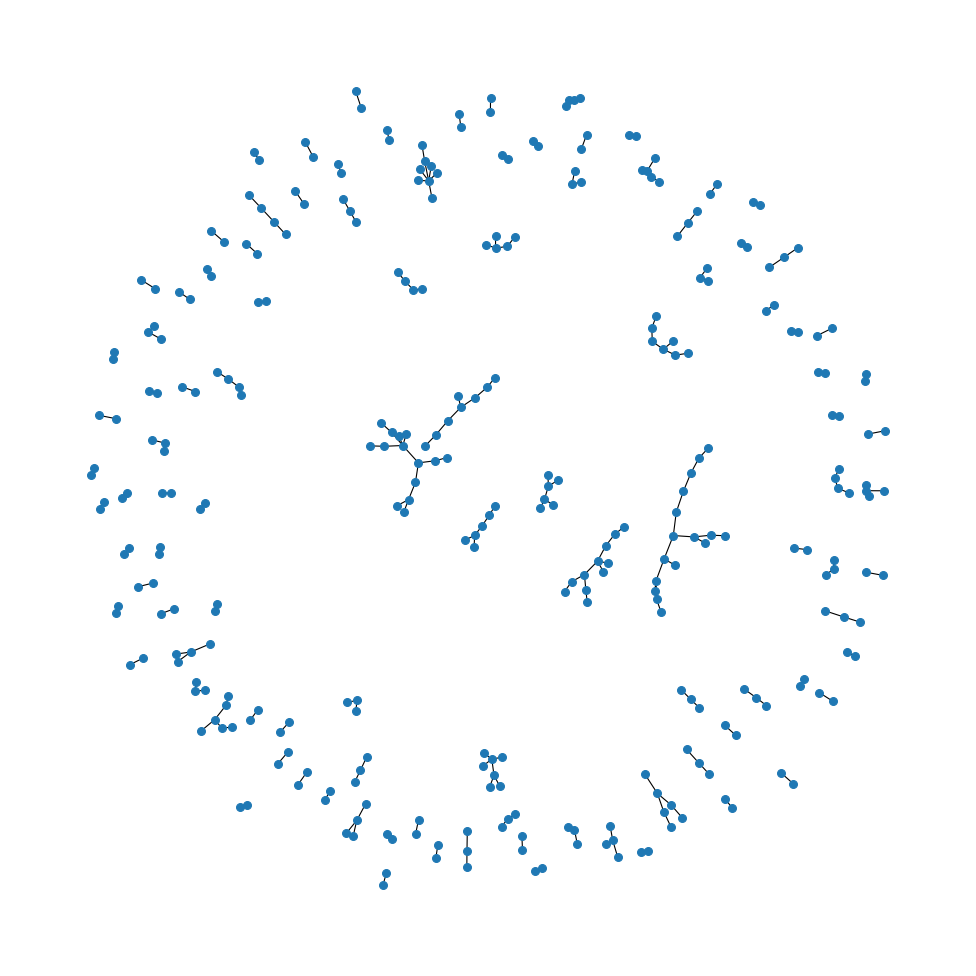

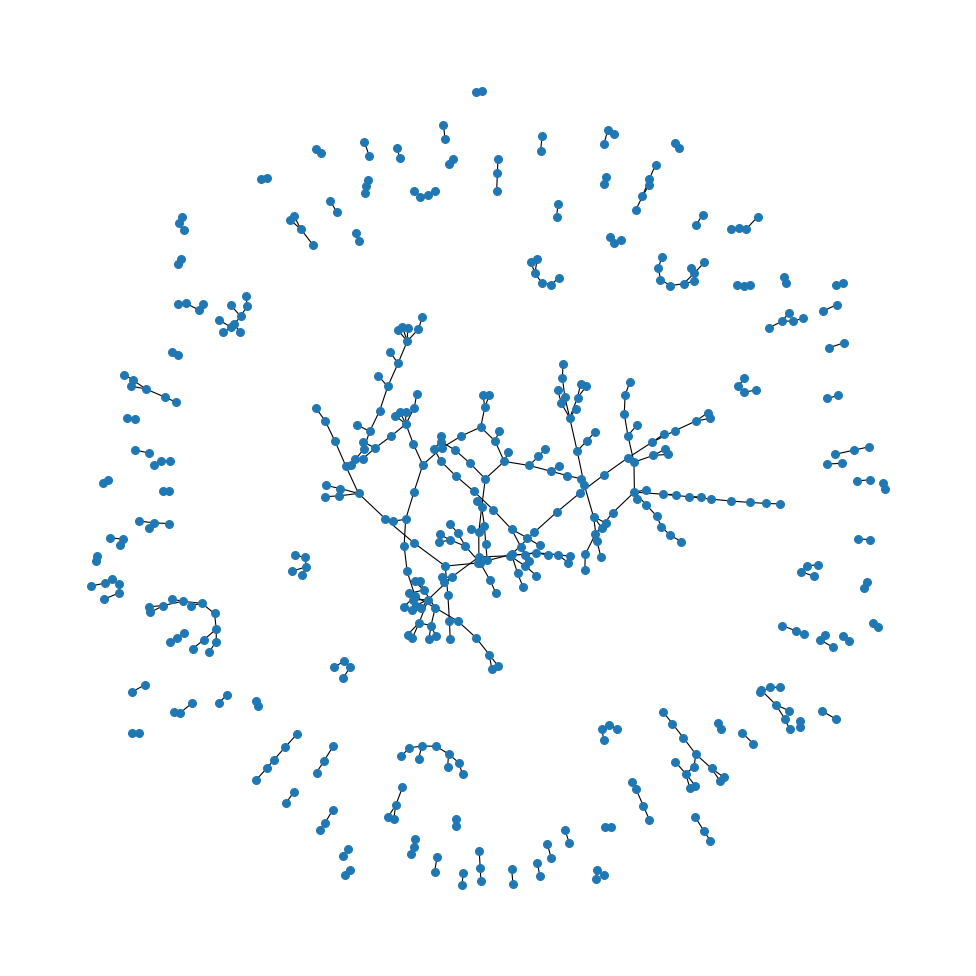

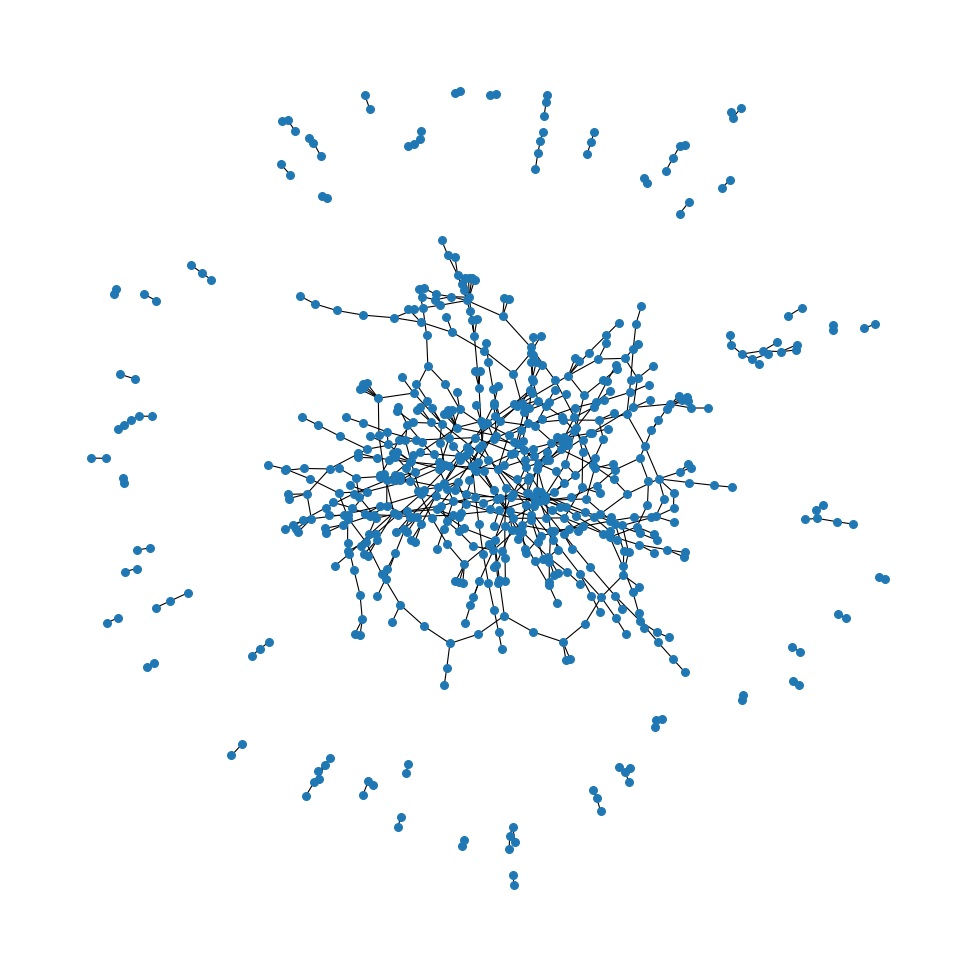

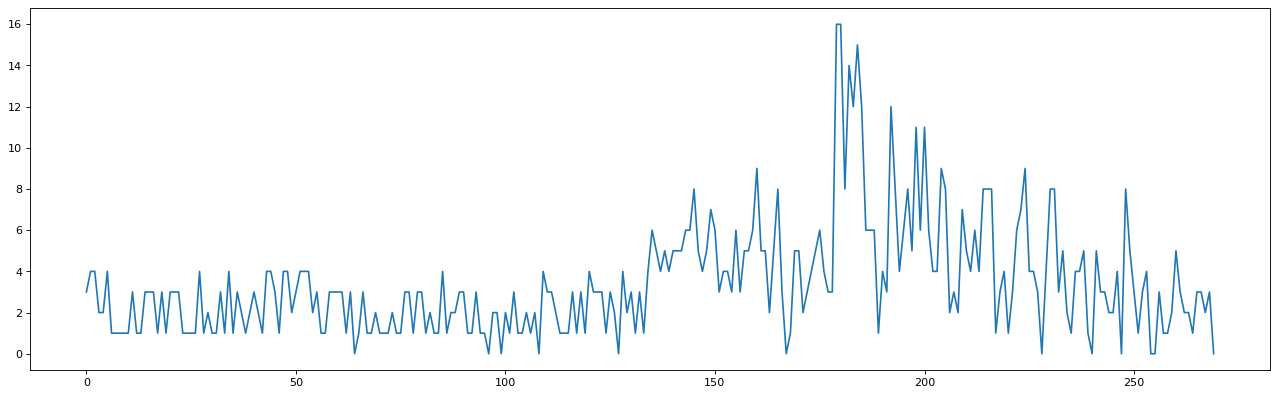

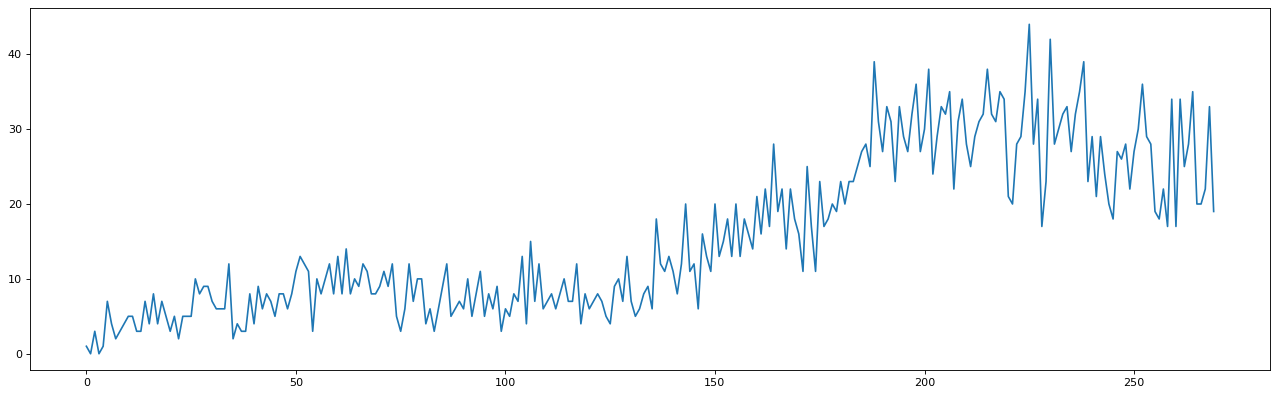

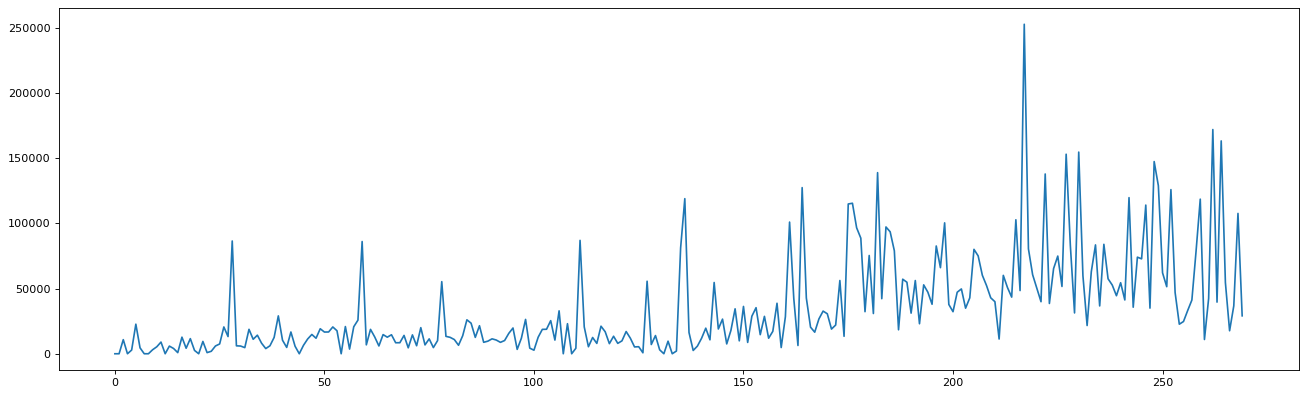

In [110]:
N_month = 9
N_days = N_month*30
N_agent = 1000
agent_top = [Agent('t') for i in range(5)]
agent_normal = [Agent('n') for i in range(N_agent-5)]
agents = agent_top + agent_normal

# different mcc with equation(slope, intercept) to calculate the carbon emission
mcc = {5999: [2.64, 155.03], 5912: [3.41, 178.03], 5311: [1.61, 24.27], 5399: [1.95, 9.82], 5735: [2.48, 91.72],
       4111: [3.70, -24.40], 4121: [3.13, -4.50], 5541: [3.49, 2653.86], 4112: [3.57, 9.54], 4131: [3.13, -14.87],
       5411: [3.63, 33.55], 5499: [3.34, 196.46],
       5812: [4.05, 833.94], 5814: [5.28, 0.38], 5813: [3.84, 7.47], 5811: [5.30, -8.65], 7999: [1.27, -13.11],
       6011: [2.29, 896.91], 4814: [3.73, 15.94], 8398: [1.72, -21.87], 8999: [2.48, 167.96], 4900: [48.97, -6.68]
      }

# prob is the probability to choose from the mcc or the categoty overall equation
other = {'prob': 8, 'mcc': [6011, 4814, 8398, 8999, 4900], 'weight': [0.715, 0.086, 0.081, 0.068, 0.050], 
         'equation': [0, 0]}

shopping = {'prob': 38, 'mcc': [5999, 5912, 5311, 5399, 5735], 'weight': [0.307, 0.249, 0.199, 0.132, 0.110],
            'equation': [1.18, 1136.39]}

travel = {'prob': 91, 'mcc': [4111, 4121, 5541, 4112, 4131], 'weight': [0.360, 0.267, 0.204, 0.085, 0.084],
          'equation': [2.62, 570.20]}

groceries = {'prob': 95, 'mcc': [5411, 5499], 'weight': [0.774, 0.226], 'equation': [3.73, -4.39]}

lifestyle = {'prob': 92, 'mcc': [5812, 5814, 5813, 5811, 7999], 'weight': [0.509, 0.260, 0.178, 0.035, 0.019],
             'equation': [1.36, 599.19]}

subscripition = {'prob': -1, 'equation':[0, 0]}

fuel = {'prob': -1, 'equation': [4.57, 456.74]}

category_list = [other, shopping, travel, groceries, lifestyle, subscripition, fuel]


network = Decision(agents, N_month, N_agent, category_list, mcc)
market = Market()
carbon_log = []
carbon_total_log = []
user_log = []
trans_log = []
for i in range(N_days):
    trans_num, user_num, carbon_daily = network.launch(agents, i+1)
    carbon_emission_total, carbon_emission = market.launch(carbon_daily)
    
    trans_log.append(trans_num)
    user_log.append(user_num)
    carbon_log.append(carbon_emission)
    carbon_total_log.append(carbon_emission_total)
    
figure(figsize=(20, 6), dpi=80)
plt.plot(range(0, N_days), user_log)

figure(figsize=(20, 6), dpi=80)
plt.plot(range(0, N_days), trans_log)
    
figure(figsize=(20, 6), dpi=80)
plt.plot(range(0, N_days), carbon_log)

#figure(figsize=(20, 6), dpi=80)
#plt.plot(range(0, N_days), carbon_total_log)
#plt.show

0